# Homework 4a Submission
## Yonadav Shavit

In [869]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.special import factorial
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(Let's define some latex commands)
 
$\newcommand{\floor}[1]{\left \lfloor #1 \right \rfloor}$
$\newcommand{\clamp}[1]{\left [ #1 \right ]}$
$\newcommand{\lap}[1]{Lap\left ( #1 \right )}$
$\newcommand{\lapcdf}[2]{LapCDF\left ( #1, [-\inf, #2] \right )}$
$\newcommand{\lappdf}[2]{LapPDF\left ( #1, |_{#2} \right )}$
$\newcommand{\lapcdffull}[2]{\frac{1}{2} + \frac{1}{2}sgn\left({#2}\right)\left ( 1 - \exp{\left ( - \frac{|#2|}{#1} \right ) }\right )}$
$\newcommand{\lappdffull}[2]{\frac{1}{2 #1} \exp{\left ( - \frac{#2}{#1}\right ) }}$

## Problem 1

### (a)

We'll be implementing two different mechanisms, both of which rely on an estimation of $p_j$.

In the local DP case, we'll compute $I(x[j] = 0 \land y = 1)$, and then return that value (or its conjugate) with probability $\frac{e^\epsilon}{1 + e^\epsilon}$, and then scale that up by a factor of $c_\epsilon = \frac{e^\epsilon + 1}{e^\epsilon - 1}$.

In the centralized DP case, we'll compute $\frac{1}{n}\sum_{i = 0}^n{I(x_i[j] = 0 \land y_i = 1)}$, and then add Laplace noise of magnitude $\frac{1}{n\epsilon}$.

In [709]:
df = pd.read_csv("../data/hw4testdata.csv")

In [710]:
X_toy = df[[col for col in df.columns if "x" in col]].values
Y_toy = df['y'].values

In [1209]:
def local_pj(Xj, Y, epsilon):
    n = Xj.shape[0]
    eeps = np.exp(epsilon)
    correct_vals = (1-Xj)*Y
    flip_bit = np.random.binomial(1, 1/(1+eeps), size=n).astype(bool)
    randomized_vals = np.logical_xor(flip_bit, correct_vals)
    c_e = (eeps + 1)/(eeps - 1)
    return c_e*randomized_vals.mean()

def lap_mechanism(epsilon, GS_q, size=None):
    return np.random.laplace(scale=GS_q/epsilon, size=size)

def dp_mean(x, epsilon, b, a=0):
    x_clipped = np.clip(x, a, b)
    GS_q = np.abs(b-a)/x.shape[0]
    return x_clipped.mean() + lap_mechanism(epsilon, GS_q)

def centralized_pj(Xj, Y, epsilon):
    return dp_mean(((1-Xj)*Y).astype(int), epsilon, b=1)

def sq_mechanism(X, Y, epsilon, t, pj_alg):
    d = X.shape[1]
    ps = np.array([pj_alg(X[:, j], Y, epsilon/d) for j in range(d)])
    S = (ps < t).astype(int)
    return S

local_sq_mechanism = lambda *args: sq_mechanism(*args, local_pj)
centralized_sq_mechanism = lambda *args: sq_mechanism(*args, centralized_pj)

def compute_statistics(S, X, Y):
    """ Error, FPR, and FNR
    """
    Yhat = ((S*X_test).sum(axis=1) == S.sum()).astype(int)
    fpr = (Yhat*(1-Y)).mean()
    fnr = ((1-Yhat)*Y).mean()
    error_rate = fpr + fnr
    return error_rate, fpr, fnr

## (b)


We will leverage the following approximation to the binomial distribution, which holds under large $n$:
$$f(x)=
\frac{n !}{x !(n-x) !} p^{x} q^{n-x} \approx 
\mathcal{N}(np, np(1-p)) = 
\frac{1}{\sqrt{2 \pi n p (1-p)}} e^{-\frac{(x-n p)^{2}}{2 n p (1-p)}} $$

First, we'll think about the global model.

Let's examine the probability that $j$ is included in $\hat{S}$ but not $S$ (i.e. false inclusion). 
Let $\epsilon_j$ be the privacy loss parameter associated with computing $p_j$ (in practice $\frac{\epsilon}{d}$).
Remember that $p_j = 0$ for $j \in S$.

$$P(j \notin \hat{S} \land j \in S) = 
P\left(0 + \lap{\frac{1}{n\epsilon_j}} > t\right) = 
1 - \left(\lapcdffull{\frac{1}{n\epsilon_j}}{t} \right)= 
\frac{1}{2}\exp{\left ( -tn\epsilon_j \right )}
$$

The probability that any of the $j$'s in $S$ is excluded from $\hat{S}$ is simply:
$$ P(S \not\subseteq \hat{S}) = 
1 - \prod_{j \in S} \left ( 1 - P(j \notin \hat{S} \land j \in S)\right ) = 
1 - \left(1 - \frac{1}{2}\exp{\left ( -tn\epsilon_j \right )} \right )^{|S|} $$

So, to ensure the false exclusion rate is below $0.1$, we need:
$$ t >  \frac{-d}{n\epsilon}\log{\left(2 - 2\sqrt[d]{0.9} \right )} $$

Next, let's think about the local model.

Note that because each response (out of $n$) used to calculate a particular $p_j$ is a single Bernoulli RV, we can treat their overall average as the response of a Bernoulli RV with $p=\frac{1}{e^{\epsilon_j} + 1}$ and $n$ trials.
The probability that $j$ is included in $\hat{S}$ but not $S$ is the same as the probability of that Bernoulli distribution reaching a value less than $\frac{tn}{c_{\epsilon_j}}$:

$$P(j \notin \hat{S} \land j \in S) =
1 - GaussianCDF\left( \frac{tn}{c_{\epsilon_j}}; \frac{n}{e^{\epsilon_j} + 1}, \frac{ne^{\epsilon_j}}{(1 + e^{\epsilon_j})^2} \right) = 
NormalCDF \left( -1 \times (e^{\epsilon_j} + 1)\frac{\frac{tn}{c_{\epsilon_j}} - \frac{n}{e^{\epsilon_j} + 1}}{e^{\epsilon_j/2}\sqrt{n}} \right ) = 
NormalCDF \left( \left (-t\left(e^{\epsilon_j} - 1\right) + 1 \right ) \frac{\sqrt{n}}{e^{\epsilon_j/2}} \right )$$

As before, the combined probability of any exclusion is:
$$ P(S \not\subseteq \hat{S}) = 
1 - \prod_{j \in S} \left ( 1 - P(j \notin \hat{S} \land j \in S)\right ) = 
1- \left (NormalCDF \left( \left (t\left(e^{\frac{\epsilon}{d}} - 1\right ) - 1 \right ) \frac{\sqrt{n}}{e^{\frac{\epsilon}{2d}}} \right ) \right )^{|S|}$$

(We'll forgo calculating an appropriate $t$ analytically, and just solve the above equation computationally given the used parameters.)

## (c)


In [1210]:
df = pd.read_csv("../data/CaPUMS5full.csv")
df['female'] = df['sex']
df = df.drop(columns=['sex'])
df.describe()

,married,black,asian,collegedegree,employed,militaryservice,uscitizen,disability,englishability,blackfemale,targetted,female
count,1.223992e+06,1.223992e+06,1.223992e+06,1.223992e+06,1.223992e+06,1.223992e+06,1.223992e+06,1.223992e+06,1.223992e+06,1.223992e+06,1.223992e+06,1.223992e+06
mean,5.543500e-01,6.290482e-02,1.232328e-01,3.037610e-01,5.905047e-01,1.313971e-01,8.124939e-01,2.358398e-01,8.785017e-01,3.324450e-02,2.538946e-01,5.120834e-01
std,4.970375e-01,2.427918e-01,3.287044e-01,4.598809e-01,4.917409e-01,3.378343e-01,3.903174e-01,4.245227e-01,3.267057e-01,1.792744e-01,4.352382e-01,4.998542e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [1211]:
train_test_split = int(0.8*df.shape[0])
features = df.drop(columns=['blackfemale', 'targetted'])
# create dummy variables for the inverse property

for col in df.columns:
    if col not in ['blackfemale', 'targetted']:
        features['not_'+col] = 1 - df[col]
X_train, X_test = features.values[:train_test_split, :], features.values[train_test_split:, :]
# Y_train, Y_test = df['blackfemale'].values[:train_test_split], df['blackfemale'].values[train_test_split:]
Y_train, Y_test = df['targetted'].values[:train_test_split], df['targetted'].values[train_test_split:]

In [1212]:
eps = 1
n_train, d_train = X_train.shape

def compute_centralized_t(n, d, eps, target_pfi=0.1):
    t_centralized = -np.log(2 - 2*(1-target_pfi)**(1/d))*d/(n*eps)
    return t_centralized

from scipy.stats import norm
def compute_local_p_false_exclusion(n, d, eps, t):
    eeps = np.exp(eps/d)
    arg = (t*(eeps - 1) - 1)*np.sqrt(n/eeps)
    p_false_inclusion = 1 - (norm.cdf(arg))**d
    return p_false_inclusion
    
tolerance = 1e-3
def compute_local_t(n, d, eps, target_pfe=0.1):
    upper = 1000
    lower = 1e-9
    i = 0
    while True:
        i += 1
        if i == 1000:
            print(i, t_guess)
            return
        t_guess = (upper + lower)/2
        pfe = compute_local_p_false_exclusion(n, d, eps, t_guess)
        if pfe > target_pfe + tolerance:
            lower = t_guess
        elif pfe < target_pfe:
            upper = t_guess
        else:
            return t_guess

In [1227]:
t_central = compute_centralized_t(n_train, d_train, eps)
t_local = compute_local_t(n_train, d_train, eps)
print(f"Centralized model t: {t_central}")
print(f"Local model t: {t_local}")

Centralized model t: 9.30477500729864e-05
Local model t: 19.555807114627903


In [1228]:
# First let's look at our ability to predict black female targetting
S_local = local_sq_mechanism(X_train, Y_train, eps, t_local)
S_centralized = centralized_sq_mechanism(X_train, Y_train, eps, t_central)
print("Attrs predicted by local model: {}".format([features.columns[i] for i in range(X_train.shape[1]) if S_local[i]]))
print("Attrs predicted by centralized model: {}".format([features.columns[i] for i in range(X_train.shape[1]) if S_centralized[i]]))

Attrs predicted by local model: ['employed', 'uscitizen', 'englishability', 'not_black', 'not_asian', 'not_militaryservice', 'not_female']
Attrs predicted by centralized model: ['employed', 'uscitizen', 'englishability', 'not_female']


In practice, employed + uscitizen + englishability + notfemale perfectly predicts the target variable, so both solutions achieved the correct outcome (with the local model having many more false positives).

In [1229]:
trials = 50
avg_err_local = 0
avg_err_centralized = 0
for _ in tqdm_notebook(range(trials)):
    S_local = local_sq_mechanism(X_train, Y_train, eps, t_local)
    S_centralized = centralized_sq_mechanism(X_train, Y_train, eps, t_central)
    avg_err_local += compute_statistics(S_local, X_test, Y_test)[0]
    avg_err_centralized += compute_statistics(S_centralized, X_test, Y_test)[0]
avg_err_local /= trials
avg_err_centralized /= trials
print(f"The average error rate with the local model was {avg_err_local}")
print(f"The average error rate with the centralized model was {avg_err_centralized}")

The average error rate with the local model was 0.08981572637143127
The average error rate with the centralized model was 0.002398947708119723


We can see that the centralized model learns almost perfectly, and the localized model learns fairly well - but has some number of false negatives (i.e. extra attributes are included and thus the model predicts positives too restrictively).

Now let's bootstrap smaller datasets to show the behavior of these methods.

In [1237]:
trials = 10
l_avg_fpr_local = []
l_avg_fpr_centralized = []
l_avg_fnr_local = []
l_avg_fnr_centralized = []
ns = np.linspace(1000, n_train, 20).astype(int)
for n in tqdm_notebook(ns.tolist()):
    indices = np.random.choice(np.arange(n_train), n, replace=False)
    X = X_train[indices, :]
    Y = Y_train[indices]
    t_central = compute_centralized_t(n, d_train, eps)
    t_local = compute_local_t(n, d_train, eps)
    fpr_local = 0
    fpr_centralized = 0
    fnr_local = 0
    fnr_centralized = 0
    for _ in range(trials):
        S_local = local_sq_mechanism(X, Y, eps, t_local)
        S_centralized = centralized_sq_mechanism(X, Y, eps, t_central)
        _, fpr, fnr = compute_statistics(S_local, X_test, Y_test)
        fpr_local += fpr; fnr_local += fnr
        _, fpr, fnr = compute_statistics(S_centralized, X_test, Y_test)
        fpr_centralized += fpr; fnr_centralized += fnr
    fpr_local /= trials
    fnr_local /= trials
    fpr_centralized /= trials
    fnr_centralized /= trials
    l_avg_fpr_local.append(fpr_local)
    l_avg_fpr_centralized.append(fpr_centralized)
    l_avg_fnr_local.append(fnr_local)
    l_avg_fnr_centralized.append(fnr_centralized)

In [1238]:
l_avg_fpr_local, l_avg_fpr_centralized, l_avg_fnr_local, l_avg_fnr_centralized = map(np.array, [l_avg_fpr_local, l_avg_fpr_centralized, l_avg_fnr_local, l_avg_fnr_centralized ])

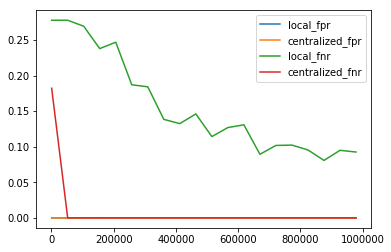

In [1239]:
plt.plot(ns, l_avg_fpr_local, label='local_fpr')
plt.plot(ns, l_avg_fpr_centralized, label='centralized_fpr')
plt.plot(ns, l_avg_fnr_local, label='local_fnr')
plt.plot(ns, l_avg_fnr_centralized, label='centralized_fnr')
plt.legend()

We can see that even at very small data quantities, the centralized model works almost perfectly. However, it takes much much more data for the local model to work well, and even after massive amounts of data it continues to have lots of false-negatives.

(The fact that the initial FNR for the centralized model is so high might be a bug in calculating $t$ for extremely small, high-noise $n$.)